# Exercise 1

- We will work with the `diabetes` data in scikit-learn (via the `load_diabetes`) function.
- Compare three methods for hyperparameter optimization for `RandomForestRegressor` with hyperparameters `max_depth`, `n_estimators`, `max_features`.
	- *Hint:* You should write a function that takes a 3-dimensional array and returns a scalar /1-d arrray.
- To compare the methods, plot the number of iterations against the loss (negative MSE). 
- Methods to compare: 	
	- Random Search (`RandomizedSearchCV`).
	- Grid Search (`GridSearchCV`).
	- Bayesian Optimization using GPy/GPyOpt.
	- Extra: Another black-box method (i.e. cross-entropy method, genetic algorithm, simulated annealing).
	
`n_estimators`: The number of trees in the forest.<br>
`max_depth`: The maximum depth of the tree.<br>
`max_features`: The number of features to consider when looking for the best split.<br>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from GPyOpt.methods import BayesianOptimization
from scipy.stats import randint

%matplotlib inline

In [5]:
X, y = load_diabetes(return_X_y=True)

In [21]:
regressor = RandomForestRegressor()

In [25]:
# Grid Search
param_grid = {
    'n_estimators': np.arange(1, 50, 7),
    'max_depth': np.arange(2, 20, 4),
    'max_features': np.arange(1, 10, 2)
}
grid_search = GridSearchCV(
    regressor, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error'
)
grid_search.fit(X,y)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 2,  6, 10, 14, 18]),
                         'max_features': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([ 1,  8, 15, 22, 29, 36, 43])},
             scoring='neg_mean_squared_error')

In [26]:
# Random Search
param_dist = {
    'n_estimators': randint(1, 50),
    'max_depth': randint(2, 20),
    'max_features': randint(1, 10)
}
randomized_search = RandomizedSearchCV(
    regressor, 
    param_distributions=param_dist, 
    scoring='neg_mean_squared_error', 
    n_iter=175 # product of the param_grid array lengths
)
randomized_search.fit(X,y)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=175,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f34189aa0d0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f34186aca60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f34186ac100>},
                   scoring='neg_mean_squared_error')

In [27]:
# Bayesian Optimization
def L(x):
    n_estimators, max_depth, max_features = x[0].astype(int)
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features
    )
    regressor.fit(X, y)
    score = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=5).mean() 
    return score

bds = [
    {
        'name': 'n_estimators', 
        'type': 'discrete', 
        'domain': (1, 50)
    },
    {
        'name': 'max_depth', 
        'type': 'discrete', 
        'domain': (2, 20)
    },
    {
        'name': 'max_features', 
        'type': 'discrete', 
        'domain': (1, 10)
    }

]

optimizer = BayesianOptimization(f=L, model_type='GP', acquisition_type='EI', domain=bds, maximize=True)
optimizer.run_optimization(max_iter=175)

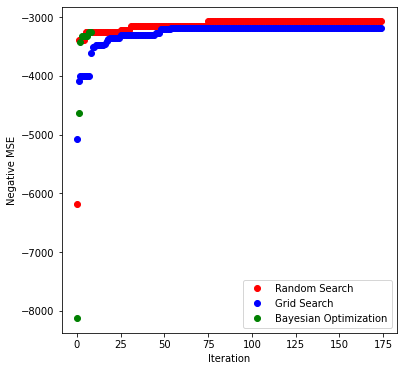

In [29]:
y_rs = np.maximum.accumulate(randomized_search.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(grid_search.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

plt.figure(figsize=(6,6))
plt.plot(y_rs, 'ro', label='Random Search')
plt.plot(y_gs, 'bo', label='Grid Search')
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='lower right');